In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import os

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [3]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, broken_file_path, training_classes, frame_num=45,
                 training_subjects=[1], training_cameras=[1, 2, 3] , transform=None):
        self.file_path = file_path
        self.broken_file_path = broken_file_path
        self.training_classes = training_classes
        self.training_subjects = training_subjects
        self.training_cameras = training_cameras
        self.transform = transform
        self.frame_num = int(frame_num)
        
        self.read_data(data_path, broken_files_path)
        self.get_dataframe()
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, idx):
        frame_len = int(self.data.shape[1] / self.frame_num)
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frame_num,frame_len)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label)
    
    def read_data(self, data_path, broken_files_path):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in self.training_classes and camera_id in self.training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename, action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)

        self.files = files
        self.action_classes = action_classes
    
    def get_dataframe(self):
        self.LABELS = {v: k for k, v in self.action_classes.items()}
        data = []
        labels = []
        ##########################################################################
        numbers = {v: 0 for k, v in self.action_classes.items()}
        ##################################################################
        for file in self.files:
            frames_blocks, label = self.create_coords_blocks(file)
#             print(frames_blocks, label)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        self.data = test_data
        
    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.frame_num * int(len(test_frames)/self.frame_num)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.frame_num:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data

In [4]:
data_path = "/home/alex/Downloads/pytorch/nturgb+d_skeletons/"
broken_files_path = "/home/alex/Downloads/pytorch/NTU_RGBD_samples_with_missing_skeletons.txt"

In [5]:
dataset = Skeleton_Dataset(data_path, broken_files_path, training_classes=[8, 10, 22, 23, 27, 21], transform=None)

action classes:  {8: 0, 23: 1, 27: 2, 22: 3, 21: 4, 10: 5}
action files:  {8: 120, 23: 120, 27: 120, 22: 120, 21: 120, 10: 120}


In [6]:
data_len = dataset.data.shape[0]
train_len = int(0.75 * dataset.data.shape[0])
test_len = data_len - train_len
LABELS = dataset.LABELS

In [7]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [8]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(300):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7798  / 8 ✗ (23)
epoch : 13 iter : 19 (0m 21s) 1.7850  / 8 ✗ (23)
epoch : 27 iter : 1 (0m 43s) 1.6526  / 22 ✗ (23)
epoch : 40 iter : 20 (1m 4s) 1.7783  / 21 ✗ (27)
epoch : 54 iter : 2 (1m 26s) 1.4231  / 22 ✗ (23)
epoch : 67 iter : 21 (1m 47s) 1.2798  / 22 ✓
epoch : 81 iter : 3 (2m 9s) 0.7790  / 21 ✗ (23)
epoch : 94 iter : 22 (2m 32s) 1.2544  / 22 ✓
epoch : 108 iter : 4 (2m 54s) 0.8624  / 8 ✓
epoch : 121 iter : 23 (3m 16s) 0.6691  / 10 ✓
epoch : 135 iter : 5 (3m 38s) 0.8916  / 21 ✗ (10)
epoch : 148 iter : 24 (4m 0s) 0.8239  / 8 ✗ (27)
epoch : 162 iter : 6 (4m 21s) 0.7907  / 8 ✓
epoch : 175 iter : 25 (4m 44s) 1.4031  / 8 ✓
epoch : 189 iter : 7 (5m 6s) 0.5213  / 23 ✓
epoch : 202 iter : 26 (5m 28s) 0.5156  / 22 ✓
epoch : 216 iter : 8 (5m 49s) 0.6373  / 22 ✓
epoch : 229 iter : 27 (6m 11s) 0.4522  / 23 ✓
epoch : 243 iter : 9 (6m 32s) 0.7633  / 10 ✗ (23)
epoch : 256 iter : 28 (6m 54s) 0.5374  / 22 ✗ (10)
epoch : 270 iter : 10 (7m 16s) 0.3189  / 23 ✓
epoch : 283 it

<IPython.core.display.Javascript object>


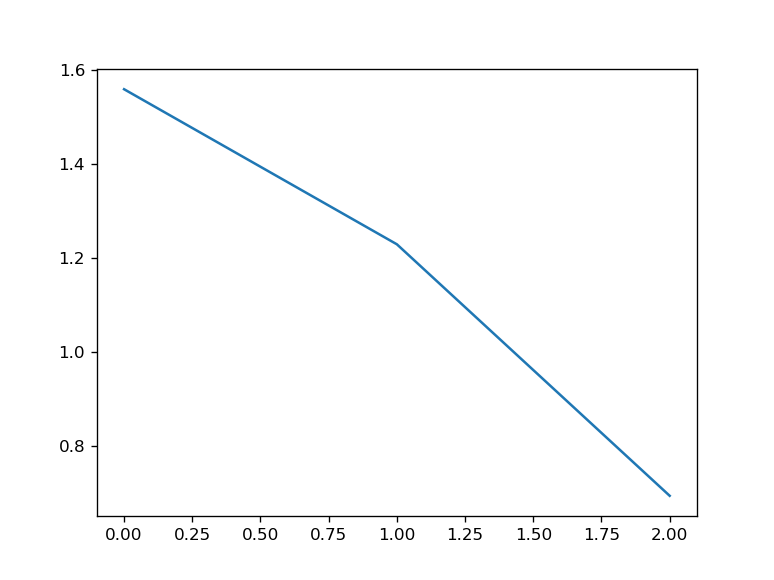

In [11]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [12]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   61.53846153846154


Попробуем добавить в нашу сеть дополнительный lstm слой, а так же дополнительный полносвязный слой. Увеличим количество эпох обучения, добавив предварительно dropout как в lstm так и в полносвязные слои

In [13]:
import torch.nn.functional as F

class LSTM_net_1(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True, dropout=0.3)
        self.fc1 = torch.nn.Linear(hidden_dim,128)
        self.fc2 = torch.nn.Linear(128,output_dim)
        self.dpo1 = nn.Dropout(0.2)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,_ = self.lstm(x)
        x = self.dpo1(F.relu(self.fc1(lstm_out[:,-1,:])))
        out = self.fc2(x)
        return out

In [14]:
n_hidden = 256
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn1 = LSTM_net_1(n_joints,n_hidden,n_categories,n_layer)
rnn1.to(device)

LSTM_net_1(
  (lstm): LSTM(75, 256, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (dpo1): Dropout(p=0.2, inplace=False)
)

Так же поменяем алгоритм оптимизации

In [15]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn1.parameters(), lr=1e-3)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn1(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.8047  / 21 ✗ (22)
epoch : 13 iter : 19 (0m 40s) 1.1697  / 21 ✓
epoch : 27 iter : 1 (1m 20s) 0.8592  / 10 ✓
epoch : 40 iter : 20 (2m 1s) 0.6649  / 8 ✗ (10)
epoch : 54 iter : 2 (2m 41s) 0.3056  / 27 ✓
epoch : 67 iter : 21 (3m 21s) 0.7079  / 27 ✓
epoch : 81 iter : 3 (4m 2s) 0.1193  / 22 ✓
epoch : 94 iter : 22 (4m 42s) 0.8774  / 8 ✓
epoch : 108 iter : 4 (5m 22s) 1.1243  / 27 ✗ (8)
epoch : 121 iter : 23 (6m 3s) 0.5215  / 21 ✓
epoch : 135 iter : 5 (6m 43s) 0.0147  / 8 ✓
epoch : 148 iter : 24 (7m 24s) 0.1572  / 21 ✗ (23)
epoch : 162 iter : 6 (8m 4s) 0.1215  / 8 ✓
epoch : 175 iter : 25 (8m 44s) 0.1548  / 23 ✓
epoch : 189 iter : 7 (9m 24s) 0.0581  / 10 ✓
epoch : 202 iter : 26 (10m 6s) 0.2475  / 21 ✓
epoch : 216 iter : 8 (10m 47s) 0.0038  / 10 ✓
epoch : 229 iter : 27 (11m 27s) 0.0155  / 27 ✓
epoch : 243 iter : 9 (12m 7s) 0.0186  / 21 ✓
epoch : 256 iter : 28 (12m 48s) 0.5623  / 23 ✓
epoch : 270 iter : 10 (13m 29s) 0.0409  / 10 ✓
epoch : 283 iter : 29 (14m 9s) 0.0193  

In [16]:
total = 0
right = 0
counter = 0

rnn1.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn1(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   84.61538461538461


Accuracy на тестовой выборке выросла с 61.538 до 84.615

# Количество кадров

Для начала получим датасет с меньшим количеством кадров, и обучим на нём нейронную сеть

In [19]:
dataset_1 = Skeleton_Dataset(data_path, broken_files_path, frame_num=20,
                             training_classes=[8, 10, 22, 23, 27, 21], transform=None)

action classes:  {8: 0, 23: 1, 27: 2, 22: 3, 21: 4, 10: 5}
action files:  {8: 120, 23: 120, 27: 120, 22: 120, 21: 120, 10: 120}


In [20]:
dataset_1.data.shape

(921, 1501)

In [24]:
data_len_1 = dataset_1.data.shape[0]
train_len_1 = int(0.75 * dataset_1.data.shape[0])
test_len_1 = data_len_1 - train_len_1
LABELS = dataset_1.LABELS

train_dataset_1, test_dataset_1 = torch.utils.data.random_split(dataset_1, [train_len_1, test_len_1])
train_loader_1 = DataLoader(train_dataset_1, batch_size = 16, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 16, shuffle=True)

In [22]:
n_hidden = 256
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn2 = LSTM_net_1(n_joints,n_hidden,n_categories,n_layer)
rnn2.to(device)

LSTM_net_1(
  (lstm): LSTM(75, 256, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (dpo1): Dropout(p=0.2, inplace=False)
)

In [23]:
def train_and_evaluate(train, test, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(600):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            output = model(inputs.float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 


            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))


            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0
            
            
    total = 0
    right = 0
    counter = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)  
            output = model(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]

            if guess == category:
                right = right + 1


    print('Accuracy of the network:  ',  (100 * right / counter))


In [25]:
train_and_evaluate(train_loader_1, test_loader_1, rnn2)

epoch : 0 iter : 0 (0m 0s) 1.7753  / 21 ✓
epoch : 11 iter : 16 (0m 22s) 1.3336  / 27 ✓
epoch : 22 iter : 32 (0m 45s) 1.2951  / 8 ✗ (27)
epoch : 34 iter : 4 (1m 8s) 0.5794  / 10 ✓
epoch : 45 iter : 20 (1m 30s) 0.8873  / 10 ✓
epoch : 56 iter : 36 (1m 50s) 0.4318  / 8 ✓
epoch : 68 iter : 8 (2m 9s) 0.6479  / 8 ✓
epoch : 79 iter : 24 (2m 29s) 0.3543  / 23 ✓
epoch : 90 iter : 40 (2m 48s) 0.3841  / 10 ✓
epoch : 102 iter : 12 (3m 7s) 0.5910  / 21 ✓
epoch : 113 iter : 28 (3m 26s) 0.0847  / 23 ✓
epoch : 125 iter : 0 (3m 46s) 0.1040  / 10 ✓
epoch : 136 iter : 16 (4m 5s) 0.1986  / 10 ✓
epoch : 147 iter : 32 (4m 25s) 0.5632  / 8 ✓
epoch : 159 iter : 4 (4m 43s) 0.0611  / 21 ✓
epoch : 170 iter : 20 (5m 2s) 0.0525  / 22 ✓
epoch : 181 iter : 36 (5m 22s) 0.0541  / 27 ✓
epoch : 193 iter : 8 (5m 41s) 0.0242  / 21 ✓
epoch : 204 iter : 24 (6m 0s) 0.2481  / 21 ✓
epoch : 215 iter : 40 (6m 19s) 0.0279  / 21 ✓
epoch : 227 iter : 12 (6m 38s) 0.0515  / 21 ✓
epoch : 238 iter : 28 (6m 57s) 0.0335  / 21 ✓
epoch : 25

И попробуем увеличить количество кадров

In [26]:
dataset_2 = Skeleton_Dataset(data_path, broken_files_path, frame_num=70,
                             training_classes=[8, 10, 22, 23, 27, 21], transform=None)

action classes:  {8: 0, 23: 1, 27: 2, 22: 3, 21: 4, 10: 5}
action files:  {8: 120, 23: 120, 27: 120, 22: 120, 21: 120, 10: 120}


In [27]:
dataset_2.data.shape

(357, 5251)

In [28]:
data_len_2 = dataset_2.data.shape[0]
train_len_2 = int(0.75 * dataset_2.data.shape[0])
test_len_2 = data_len_2 - train_len_2
LABELS = dataset_2.LABELS

train_dataset_2, test_dataset_2 = torch.utils.data.random_split(dataset_2, [train_len_2, test_len_2])
train_loader_2 = DataLoader(train_dataset_2, batch_size = 16, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 16, shuffle=True)

In [29]:
n_hidden = 256
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn3 = LSTM_net_1(n_joints,n_hidden,n_categories,n_layer)
rnn3.to(device)

LSTM_net_1(
  (lstm): LSTM(75, 256, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (dpo1): Dropout(p=0.2, inplace=False)
)

In [30]:
train_and_evaluate(train_loader_2, test_loader_2, rnn3)

epoch : 0 iter : 0 (0m 0s) 1.7596  / 23 ✗ (22)
epoch : 29 iter : 7 (0m 56s) 1.2956  / 22 ✓
epoch : 58 iter : 14 (1m 54s) 0.8981  / 23 ✗ (10)
epoch : 88 iter : 4 (2m 51s) 0.5559  / 8 ✓
epoch : 117 iter : 11 (3m 47s) 0.2674  / 21 ✓
epoch : 147 iter : 1 (4m 43s) 0.3702  / 21 ✗ (22)
epoch : 176 iter : 8 (5m 40s) 0.1723  / 10 ✓
epoch : 205 iter : 15 (6m 36s) 0.0538  / 23 ✓
epoch : 235 iter : 5 (7m 33s) 0.0143  / 10 ✓
epoch : 264 iter : 12 (8m 29s) 0.0026  / 21 ✓
epoch : 294 iter : 2 (9m 26s) 0.0007  / 10 ✓
epoch : 323 iter : 9 (10m 22s) 0.5050  / 8 ✓
epoch : 352 iter : 16 (11m 18s) 1.7557  / 23 ✓
epoch : 382 iter : 6 (12m 15s) 0.0060  / 10 ✓
epoch : 411 iter : 13 (13m 11s) 0.0196  / 21 ✓
epoch : 441 iter : 3 (14m 8s) 0.0494  / 8 ✓
epoch : 470 iter : 10 (15m 5s) 0.5629  / 23 ✓
epoch : 500 iter : 0 (16m 2s) 0.0201  / 8 ✓
epoch : 529 iter : 7 (16m 58s) 0.0085  / 22 ✓
epoch : 558 iter : 14 (17m 54s) 0.0045  / 23 ✓
epoch : 588 iter : 4 (18m 51s) 0.0006  / 21 ✓
Accuracy of the network:   100.0


Результат получился очень хороший, и весьма предсказуемый. Увеличение количества кадров позволило существенно увеличить качество модели.